# ML lab 06

# Linear classification

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install tensorflow --user
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from datetime import timedelta

from sklearn.model_selection import train_test_split,  KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.metrics import confusion_matrix, \
                  classification_report, accuracy_score,  precision_score, recall_score, f1_score

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
sns.set()
pd.set_option('precision', 3)

In [3]:
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123) # for reproducibility

### Suport functions

In [4]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

## SECTION 1. Linear Classification on wine data

 We have the results of an analysis on wines grown in a region in Italy but derived from three different cultivars.
The analysis determined the quantities of 13 chemical constituents found in each of the three types of wines. 
The goal is to separate the three types of wines. 

For increasing the interest on the exercise we will asume that one of the wine types is cheap, the second is normal, and the third is expensive. Our objective here will be to make a classifier that labels the wine its category price. 

In [5]:
wine = pd.read_csv("wine.data", delimiter=',', header=None)
wine_classes = ['cultivar %d'%(i+1) for i in range(3)]
wine.shape
wine.columns = ['wine_type','alcohol','malic_acid','ash',
                'alcalinity_of_ash','magnesium','total_phenols',
                'flavanoids','nonflavanoid_phenols',
                'proanthocyanins','color_intensity','hue',
                'OD280/OD315','proline']

wine['wine_type'] = wine['wine_type'].map({1:'cheap', 2:'normal', 3:'expensive'})

wine.wine_type = wine.wine_type.astype(CategoricalDtype(categories=['cheap', 'normal', 'expensive'],  
                                                        ordered=True))

wine.describe(include='all')

(178, 14)

,wine_type,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315,proline
count,178,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000,178.000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,13.001,2.336,2.367,19.495,99.742,2.295,2.029,0.362,1.591,5.058,0.957,2.612,746.893
std,NaN,0.812,1.117,0.274,3.340,14.282,0.626,0.999,0.124,0.572,2.318,0.229,0.710,314.907
min,NaN,11.030,0.740,1.360,10.600,70.000,0.980,0.340,0.130,0.410,1.280,0.480,1.270,278.000
25%,NaN,12.362,1.603,2.210,17.200,88.000,1.742,1.205,0.270,1.250,3.220,0.782,1.938,500.500
50%,NaN,13.050,1.865,2.360,19.500,98.000,2.355,2.135,0.340,1.555,4.690,0.965,2.780,673.500
75%,NaN,13.678,3.083,2.558,21.500,107.000,2.800,2.875,0.438,1.950,6.200,1.120,3.170,985.000


If we do a fast pairplot we can see that this dataset is going to be an easy one. The scatterplots are showing clear separation on some variables, and it looks like we would be able to predict the class with only a subset on the variables, like for example Alcohol and OD280/OD315.

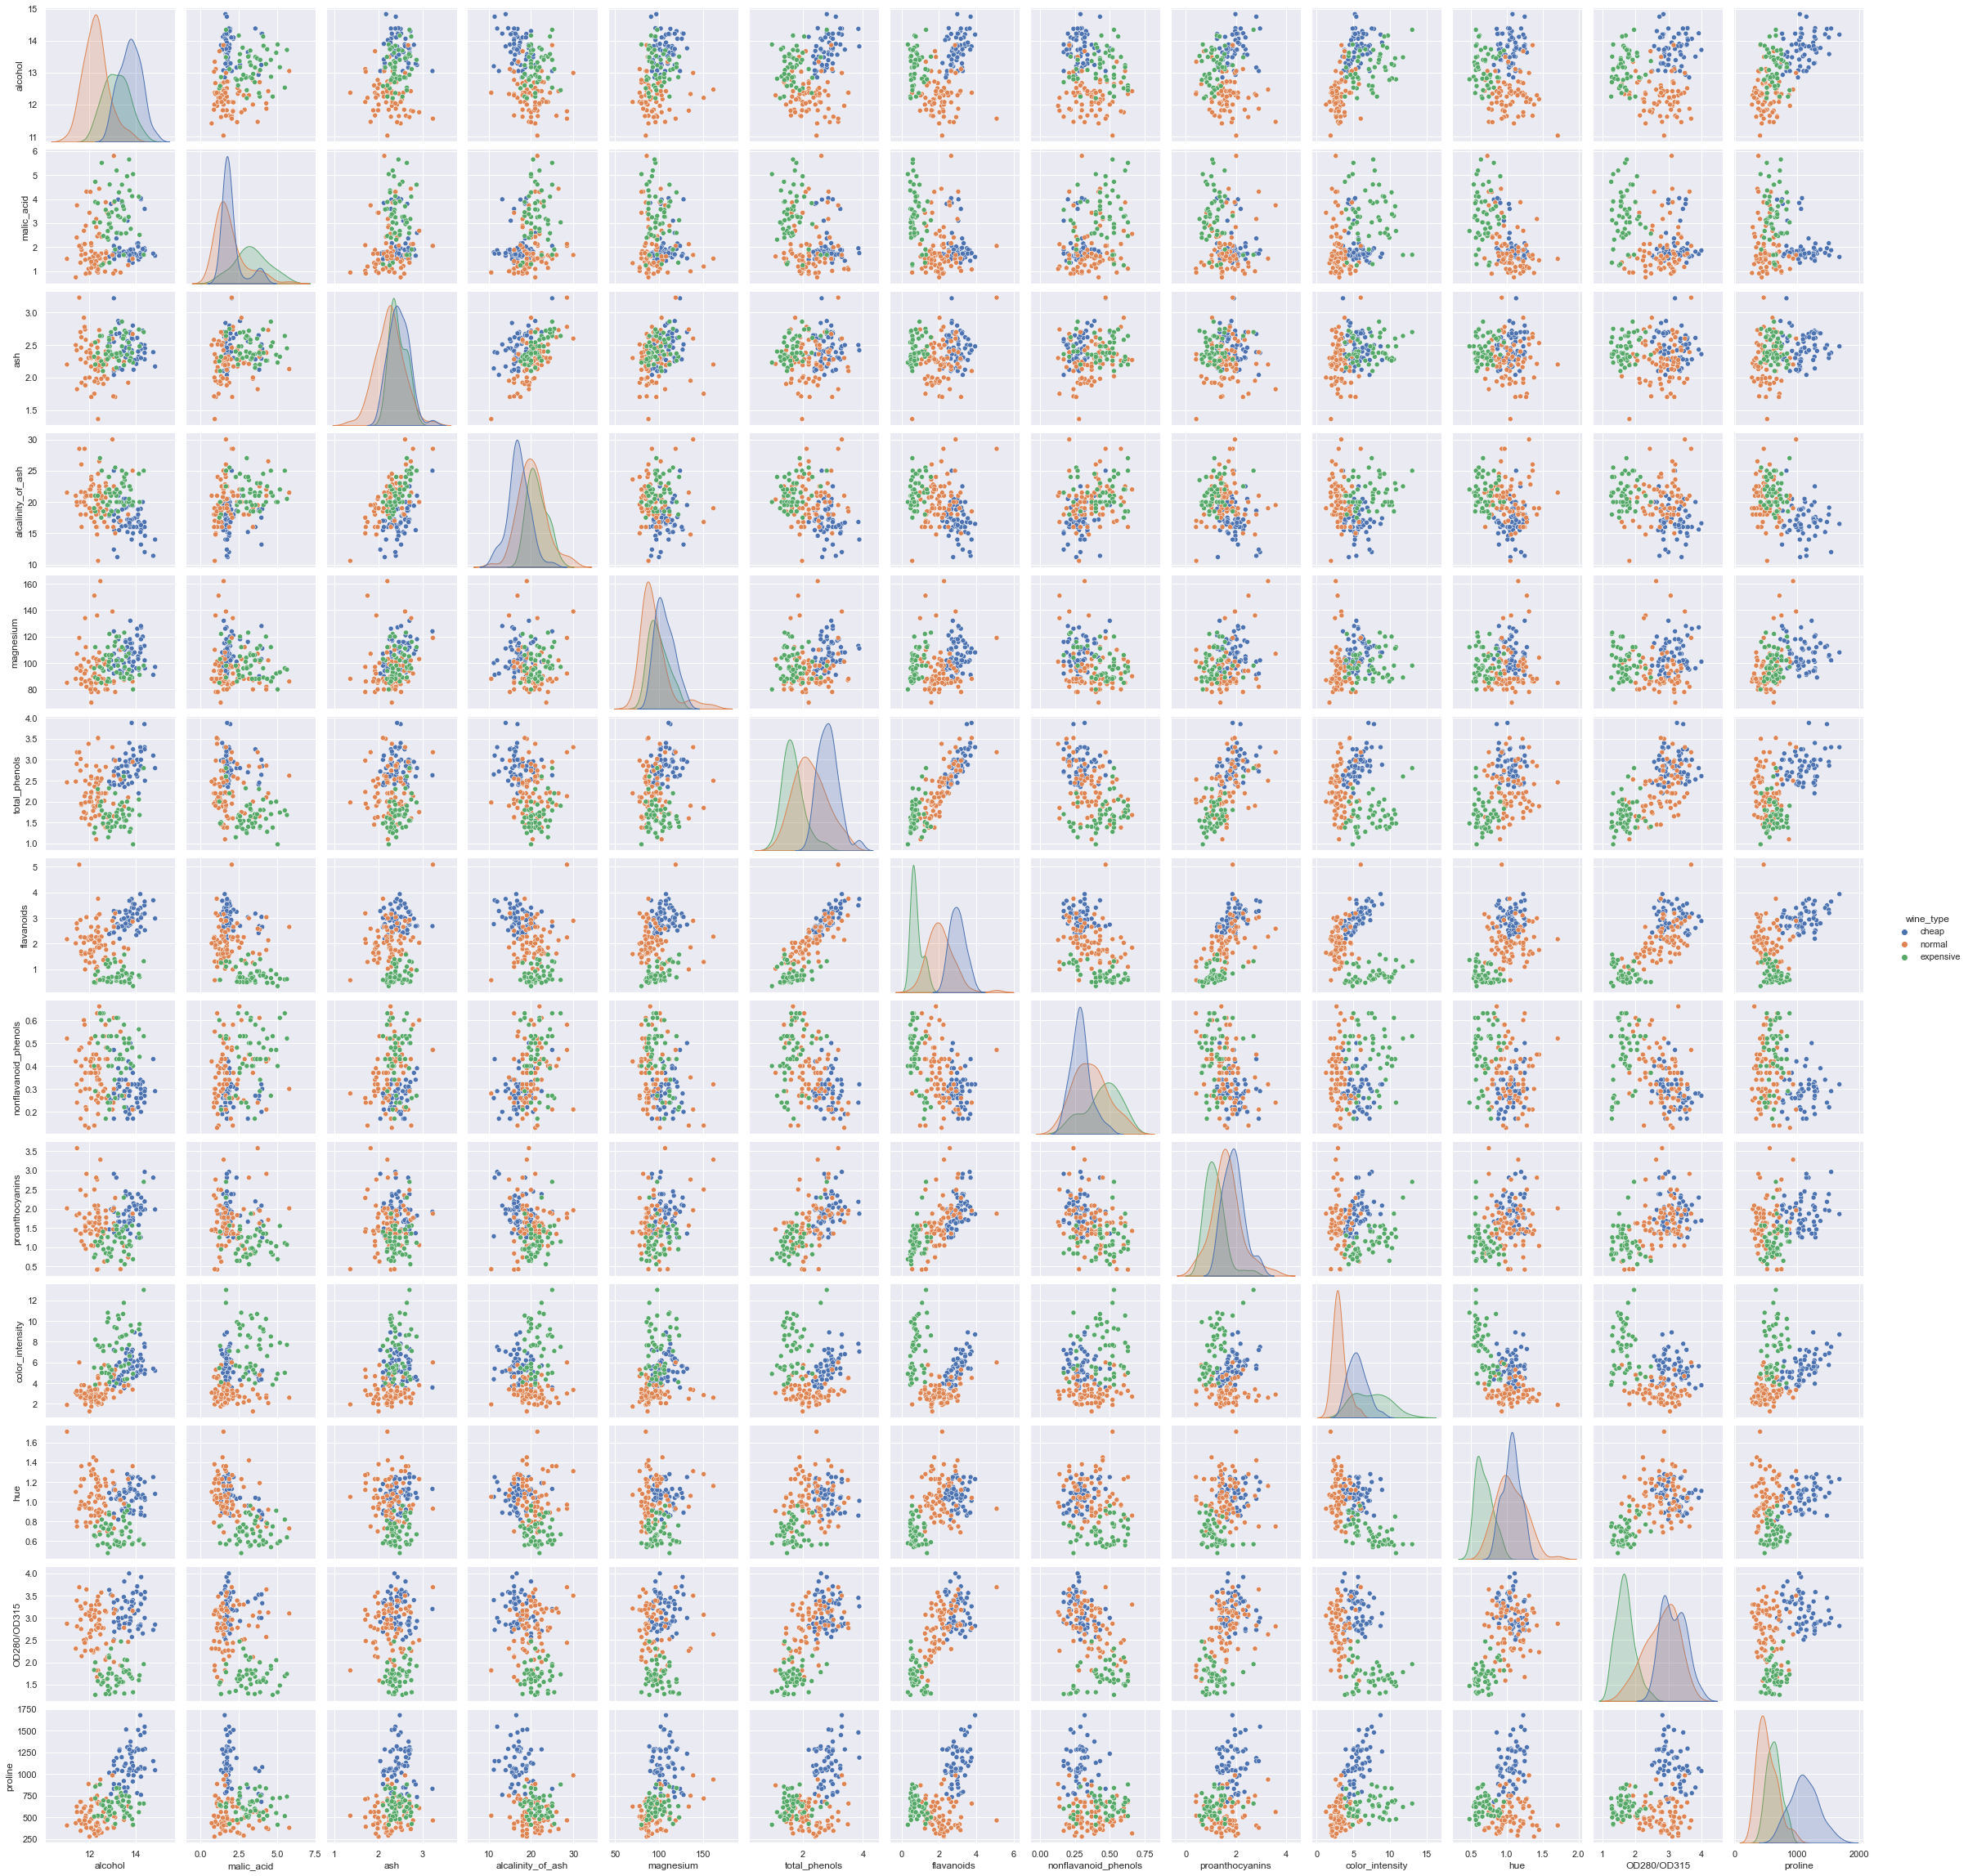

In [6]:
sns.pairplot(data=wine, hue='wine_type');

### Resampling protocol

We will use two data partitions (train and test) with 5-fold cross-validation over the train partition for deciding hyperparameters. 
For comparing models we will use 5-fold cross-validation metrics.

We have chosen this strategy because we have very few samples (178) and we are going to use quite fast models on this lab. 

In [7]:
X = wine.loc[:,wine.columns != 'wine_type']
y = wine['wine_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Preprocessing

Our variables are showing different ranges, we are going to scale them because we don't want this to interfere with our models' performance. *Notice that the scaling process is different for the training and the test set; this is to make things compatible with the fact that we cannot use information from the test set to do the scaling*

In [8]:
def preprocessing(X, y, scaler=None):    
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    else: 
        X = scaler.transform(X) 
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

### LDA

Read explanation at https://scikit-learn.org/stable/modules/lda_qda.html.

LDA tries to model the probability $p(y=C_k|X=x)$ by assuming: 
* $p(x|C_k)$ is Gaussian (which means that can be described by $\mu_k$ and $\Sigma_k$)
* All covariance matrix are the same ($\Sigma_k = \Sigma$)

By using bayes formula ($p(A|B) = \frac{P(B|A)P(A)}{P(B)}$) and all these asumptions, we obtain the next discriminant function:

$a_k(x) = x^T_k\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

$log P(y = k|x) = w^t_kx + w_{k0} + Cst$

Where $\pi_k$ are the prior probabilities. 

If we call:

$w = \Sigma^{-1}\mu_k$

$w_0=- \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + log(\pi_k)$

We obtain a linear representation of the formula.

In [9]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

print('Priors:', lda_model.priors_)
print('Means:\n')
means =pd.DataFrame(lda_model.means_)
means.columns=wine.columns[1:]
means.index = lda_model.classes_
means
print('Coefs:')
coefs = pd.DataFrame(lda_model.coef_)
coefs.columns =wine.columns[1:]
coefs.index = lda_model.classes_
coefs.T

print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
intercepts.index = lda_model.classes_
intercepts

print('Explained Variance Ratio')
pd.DataFrame(lda_model.explained_variance_ratio_ )

LinearDiscriminantAnalysis()

Priors: [0.32773109 0.27731092 0.39495798]
Means:



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315,proline
cheap,0.719,0.228,0.577,0.318,0.410,0.648,0.558,0.323,0.478,0.412,0.474,0.697,0.646
expensive,0.541,0.512,0.575,0.550,0.327,0.228,0.093,0.582,0.212,0.607,0.168,0.133,0.278
normal,0.317,0.237,0.488,0.521,0.280,0.436,0.366,0.441,0.391,0.150,0.469,0.556,0.194


Coefs:


,cheap,expensive,normal
alcohol,9.667,-1.280,-7.123
malic_acid,-0.883,4.831,-2.660
ash,8.807,5.916,-11.462
alcalinity_of_ash,-16.129,7.481,8.131
magnesium,0.153,0.268,-0.315
total_phenols,-5.555,9.272,-1.900
flavanoids,22.465,-35.123,6.020
nonflavanoid_phenols,1.677,-4.196,1.555
proanthocyanins,-3.602,-0.210,3.136
color_intensity,-7.778,17.723,-5.990


Intercepts:


,0
cheap,-23.940
expensive,-1.846
normal,2.580


Explained Variance Ratio


,0
0,0.705
1,0.295


We can see now an example of how the model is predicting the class of a single sample.

In [10]:
sample = X_train[0,:]
sample_value = y_train[0]

sample

array([0.70526316, 0.19755601, 0.53475936, 0.30927835, 0.33695652,
       0.56206897, 0.53586498, 0.26415094, 0.40189873, 0.22737307,
       0.51219512, 1.        , 0.5965327 ])

The model coeficients correspond to the $w$ in our linear formula and the intercept corresponds to the $w_0$. 

We can use them to obtain the decision function values of our sample. We will predict the class with the biggest value.

In [11]:
np.matmul(lda_model.coef_, sample) + lda_model.intercept_

array([  9.70606445, -31.04493708,  -4.83824262])

We can also compute this using the decision function implemented on the lda class.

In [13]:
lda_model.decision_function(sample.reshape(1, -1))

array([[  9.70606445, -31.04493708,  -4.83824262]])

In this case the prediction would be cheap, as it is the category codified first on the model. 

In [14]:
lda_model.classes_

array(['cheap', 'expensive', 'normal'], dtype='<U9')

We can also use predict method. 

In [15]:
print('Prediction: {}\nReal value: {}'.format(lda_model.predict(sample.reshape(1, -1))[0], sample_value) )

Prediction: cheap
Real value: cheap


A big advantage for the LDA model is that it can also perform dimensionality reduction. We can now check the projection of the data into the first two components.

In [16]:
y_train

22         cheap
146    expensive
97        normal
69        normal
167    expensive
         ...    
71        normal
106       normal
14         cheap
92        normal
102       normal
Name: wine_type, Length: 119, dtype: category
Categories (3, object): ['cheap' < 'normal' < 'expensive']

In [17]:
X_transformed = lda_model.transform(X_train)

X_transformed = pd.DataFrame(X_transformed)
X_transformed['labels'] = y_train.reset_index(drop=True)
X_transformed

,0,1,labels
0,-4.907,-0.761,cheap
1,4.478,-1.443,expensive
2,-1.197,2.932,normal
3,-0.497,2.900,normal
4,5.016,-2.134,expensive
...,...,...,...
114,-0.998,1.681,normal
115,-1.067,2.590,normal
116,-5.349,-3.679,cheap
117,0.695,2.197,normal


It looks like it is separating well the samples. Now let's evaluate our results.

<AxesSubplot:xlabel='0', ylabel='1'>

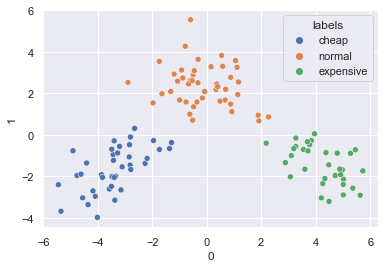

In [18]:
sns.scatterplot(x= 0, y= 1, data = X_transformed, hue='labels')

We can see on the confusion matrix that on the train data we are obtaining a perfect classification. 

In [19]:
confusion(y_train, pd.Series(lda_model.predict(X_train)))    

predicted,cheap,normal,expensive
target,,,
cheap,39,0,0
normal,0,47,0
expensive,0,0,33


### Choosing our metrics

Now we are going to compute our cross validation metrics. 



Last time we focussed on Accuracy and Recall. This time we are adding other metrics that are comonly used on classification problems. 


**Accuracy:**

$$accuracy = \frac{\sum_c tp_c}{n}$$

Where tp_c are the true positive predictions for all the classes and n are the total number of samples. This metric is **sensitive to imbalanced data**.

**Precision (of a class):**

$$precision_c = \frac{tp}{tp + fp}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and fp are the false positives (samples from another class predicted incorrectly as this class). This metric measures how much the model is predicting correctly a class with respect all the predictions of this class. We will use this metric when having false positive predictions is very harmful in our model context. 


**Recall (of a class):**

$$recall_c = =\frac{tp}{tp + fn}$$

Where $tp$ are the true positives (samples correctly predicted of this class) and fn are the false negatives (samples from this class predicted incorrectly as a different class). This metric measures how much the model is predicting correctly a class with respect all the real values of this class. We will use this metric when having false negative predictions is very harmful in our model context.

**F1-score (of a class):**

$$\frac{2 * precission_c * recall_c }{precission_c + recall_c}$$

The **harmonic mean** of precision and recall. We will use this metric when we want a good balance between precision and recall.  

We are going to use the: Accuracy, F1 macro, precission macro and recall macro metrics. 

These metrics will give us a precise view of how our model is performing. In this particular problem all the categories are equally important, as we don't want either angry customers or angry sellers. For this reason we will use the macro average of our metrics instead of focusing on the metrics of one specific class. The macro average means averaging the class-metrics.

We will use the accuracy metric because classes are more or less balanced. If classes were strongly unbalanced, accuracy would not be a good metric choice, as it could be deceiving. 

In [20]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

In [21]:
cross_val_results = pd.DataFrame(cross_validate(lda_model , X_train, y_train, cv = 5, 
                            scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['LDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.975,0.975,0.975,0.978


###  QDA

QDA is very similar to LDA.  The main difference is that in this model we do not assume that all the classes have the same covariance. This leads to obtaining a quadratic decision surface. This model can also be regularized with its regularization parameter.

In [22]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=0.1).fit(X_train, y_train)

print('Priors:', qda_model.priors_)
print('Means:\n')
means =pd.DataFrame(qda_model.means_)
means.columns=wine.columns[1:]
means

Priors: [0.32773109 0.27731092 0.39495798]
Means:



,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315,proline
0,0.719,0.228,0.577,0.318,0.410,0.648,0.558,0.323,0.478,0.412,0.474,0.697,0.646
1,0.541,0.512,0.575,0.550,0.327,0.228,0.093,0.582,0.212,0.607,0.168,0.133,0.278
2,0.317,0.237,0.488,0.521,0.280,0.436,0.366,0.441,0.391,0.150,0.469,0.556,0.194


Now the prediction on the train data is _almost_ perfect. There are three normal wines that the model confused.

In [23]:
confusion(y_train, pd.Series(qda_model.predict(X_train)))     

predicted,cheap,normal,expensive
target,,,
cheap,39,0,0
normal,1,44,2
expensive,0,0,33


If we compute again or cv metrics we can see that there is not a lot of difference but LDA is wining. That might be because our dataset is too easy, which makes it difficult to compare the models (since all of them do very well). *Remember this when you chose your dataset for the final project*

In [24]:
cross_val_results = pd.DataFrame(cross_validate(qda_model , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['QDA',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.975,0.975,0.975,0.978
QDA,0.967,0.967,0.967,0.971


### $k$-NN

$k$-nn stores the training set samples and uses them to classify the new ones. Each new sample will go to the class with the most similar values from the train set (in terms of a specific distance).

The $k$ value tells how many samples will be used to compare. 

We are going to use gridsearch cross-validation to decide which one is the best $k$ and the best distance metric for our data. 

In [25]:
knn = KNeighborsClassifier()

knn_cv = GridSearchCV(
    estimator=knn,
    param_grid={
        'n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'metric': ['euclidean', 'minkowski', 'manhattan']
    },
    scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'],
    refit=False
)

knn_cv.fit(X_train, y_train)
results_cv = pd.DataFrame(knn_cv.cv_results_)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 10, 15, 20]},
             refit=False,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [26]:
results_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_metric', 'param_n_neighbors', 'params', 'split0_test_accuracy',
       'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy',
       'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_f1_macro', 'split1_test_f1_macro',
       'split2_test_f1_macro', 'split3_test_f1_macro', 'split4_test_f1_macro',
       'mean_test_f1_macro', 'std_test_f1_macro', 'rank_test_f1_macro',
       'split0_test_precision_macro', 'split1_test_precision_macro',
       'split2_test_precision_macro', 'split3_test_precision_macro',
       'split4_test_precision_macro', 'mean_test_precision_macro',
       'std_test_precision_macro', 'rank_test_precision_macro',
       'split0_test_recall_macro', 'split1_test_recall_macro',
       'split2_test_recall_macro', 'split3_test_recall_macro',
       'split4_test_recall_macro', 'mean_test_recall_macro',
       '

In [27]:
cols = ['param_n_neighbors', 'param_metric',
     'mean_test_accuracy',
    'mean_test_f1_macro', 'mean_test_precision_macro',
    'mean_test_recall_macro', 
    'std_test_accuracy', 'std_test_f1_macro', 'std_test_precision_macro',
    'std_test_recall_macro'
]
results_cv[cols].sort_values(by='mean_test_f1_macro',ascending=False)

,param_n_neighbors,param_metric,mean_test_accuracy,mean_test_f1_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_f1_macro,std_test_precision_macro,std_test_recall_macro
10,7,minkowski,0.975,0.976,0.976,0.979,0.020,0.020,0.020,0.018
4,10,euclidean,0.975,0.976,0.976,0.979,0.020,0.020,0.020,0.018
11,10,minkowski,0.975,0.976,0.976,0.979,0.020,0.020,0.020,0.018
3,7,euclidean,0.975,0.976,0.976,0.979,0.020,0.020,0.020,0.018
20,20,manhattan,0.975,0.976,0.977,0.979,0.033,0.032,0.029,0.029
6,20,euclidean,0.966,0.967,0.967,0.971,0.017,0.016,0.017,0.015
13,20,minkowski,0.966,0.967,0.967,0.971,0.017,0.016,0.017,0.015
14,1,manhattan,0.966,0.967,0.966,0.971,0.017,0.017,0.017,0.015
16,5,manhattan,0.958,0.959,0.961,0.964,0.026,0.025,0.022,0.023
5,15,euclidean,0.958,0.959,0.960,0.962,0.028,0.027,0.025,0.027


It looks like the parameters don't affect the model performance by much this time. We will take $k$=7 and distance = 'minkowski' and add $k$-nn to our results table.

In [28]:
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)

cross_val_results = pd.DataFrame(cross_validate(knn , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['KNN',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

KNeighborsClassifier(n_neighbors=7)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.975,0.975,0.975,0.978
QDA,0.967,0.967,0.967,0.971
KNN,0.975,0.976,0.976,0.979


### Gaussian Naive Bayes

The next model we are going to use is Gaussian Naive Bayes. 

Naive Bayes assumes that the attributes of the class conditional probabilities are independent and a certain distribution for them based on the kind of data we are working with.

For example: if we are working with numerical variables it will assume that the features are conditionally independent between them and that they follow a Gaussian distribution.

In [29]:
gaussian_nb = GaussianNB()

gaussian_nb.fit(X_train,y_train)


cross_val_results = pd.DataFrame(cross_validate(gaussian_nb , X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['Gaussian Naive Bayes',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values
results_df

GaussianNB()

,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.975,0.975,0.975,0.978
QDA,0.967,0.967,0.967,0.971
KNN,0.975,0.976,0.976,0.979
Gaussian Naive Bayes,0.975,0.976,0.977,0.977


### Logistic regression

Finally, we apply logistic regression to see if it improves performance over the previous models.
We use the regularized version, and will optimize its regularization parameter 'C' using cross-validation as usual.


In [30]:
logreg = LogisticRegressionCV(Cs=20, random_state=1, cv = 10, scoring = 'accuracy', multi_class='multinomial')

logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, cv=10, multi_class='multinomial', random_state=1,
                     scoring='accuracy')

In [31]:
# figure out optimal parameter value for 'C'

avg_crossval_scores = logreg.scores_['normal'].mean(axis=0)
idx = np.argmax(avg_crossval_scores)
best_C = logreg.Cs_[idx]
print(best_C)

11.288378916846883


Let us use the optimal C found in the cross-val metrics for our results table

In [32]:
logreg = LogisticRegression(C=best_C, multi_class='multinomial')
cross_val_results = pd.DataFrame(cross_validate(logreg, X_train, y_train, cv = 5, scoring = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'] ))

results_df.loc['Logistic Regression',:] = cross_val_results[['test_accuracy', 'test_f1_macro',
       'test_precision_macro', 'test_recall_macro']].mean().values

results_df.sort_values(by='Accuracy', ascending=False)

,Accuracy,F1 Macro,Precision Macro,Recall Macro
Logistic Regression,0.983,0.983,0.982,0.986
KNN,0.975,0.976,0.976,0.979
Gaussian Naive Bayes,0.975,0.976,0.977,0.977
LDA,0.975,0.975,0.975,0.978
QDA,0.967,0.967,0.967,0.971


Our results show that Gaussian Naive Bayes is the best model for our wine data, we saw at the beggining that this dataset was extreamly easy, so it makes sense that results are so good and so close. We can also see that the models that have performed better are the most simple ones. 

### See generalization performance

Now we can chose **Logistic regression** as our best model for the wine data. As there are no more decisions to take we can now check the generalization performance of our best model. To ensure that this generalization performance is the closest posible to the performance we would obtain on new data, we are going to use our test partition to evaluate it. 

This time we can see the confusion matrix, as well as the classification report for the test set. This will give us the most detailed possible information about our results.

In [33]:
y_pred = logreg.fit(X_train, y_train).predict(X_test)

confusion(y_test, pd.Series(y_pred))

print(classification_report(y_test, y_pred))

predicted,cheap,normal,expensive
target,,,
cheap,20,0,0
normal,0,24,0
expensive,0,0,15


              precision    recall  f1-score   support

       cheap       1.00      1.00      1.00        20
   expensive       1.00      1.00      1.00        15
      normal       1.00      1.00      1.00        24

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59



Our results show that our simple model has been able to predict perfectly our simple test data. Usually, if we obtain perfect results we should be worried, as normally we only obtain them if we make a mistake on the code. But in this particular situation we can belive our results, as we were solving a toy problem.

## SECTION 2. Heart Dataset 
Now we are going to classify a more difficult dataset: Our goal now is to predict whether a patient has a heart disease using medical data (https://www.kaggle.com/ronitf/heart-disease-uci). 

In this context we don't want to miss any patient with the disease, as she might die. We should take this into account when we select our metrics.


In [34]:
heart = pd.read_csv("heart.csv", delimiter=',')

numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical_cols = ['sex', 'cp', 'exang',  'fbs', 'restecg', 'slope', 'ca', 'thal']

target = 'target'

heart[categorical_cols] = heart[categorical_cols].astype('category')

heart.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000,303.0,303.0,303.000,303.000,303.0,303.0,303.000,303.0,303.000,303.0,303.0,303.0,303.000
unique,NaN,2.0,4.0,NaN,NaN,2.0,3.0,NaN,2.0,NaN,3.0,5.0,4.0,NaN
top,NaN,1.0,0.0,NaN,NaN,0.0,1.0,NaN,0.0,NaN,2.0,0.0,2.0,NaN
freq,NaN,207.0,143.0,NaN,NaN,258.0,152.0,NaN,204.0,NaN,142.0,175.0,166.0,NaN
mean,54.366,NaN,NaN,131.624,246.264,NaN,NaN,149.647,NaN,1.040,NaN,NaN,NaN,0.545
std,9.082,NaN,NaN,17.538,51.831,NaN,NaN,22.905,NaN,1.161,NaN,NaN,NaN,0.499
min,29.000,NaN,NaN,94.000,126.000,NaN,NaN,71.000,NaN,0.000,NaN,NaN,NaN,0.000
25%,47.500,NaN,NaN,120.000,211.000,NaN,NaN,133.500,NaN,0.000,NaN,NaN,NaN,0.000
50%,55.000,NaN,NaN,130.000,240.000,NaN,NaN,153.000,NaN,0.800,NaN,NaN,NaN,1.000
75%,61.000,NaN,NaN,140.000,274.500,NaN,NaN,166.000,NaN,1.600,NaN,NaN,NaN,1.000


In [35]:
heart.columns[:-1]

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

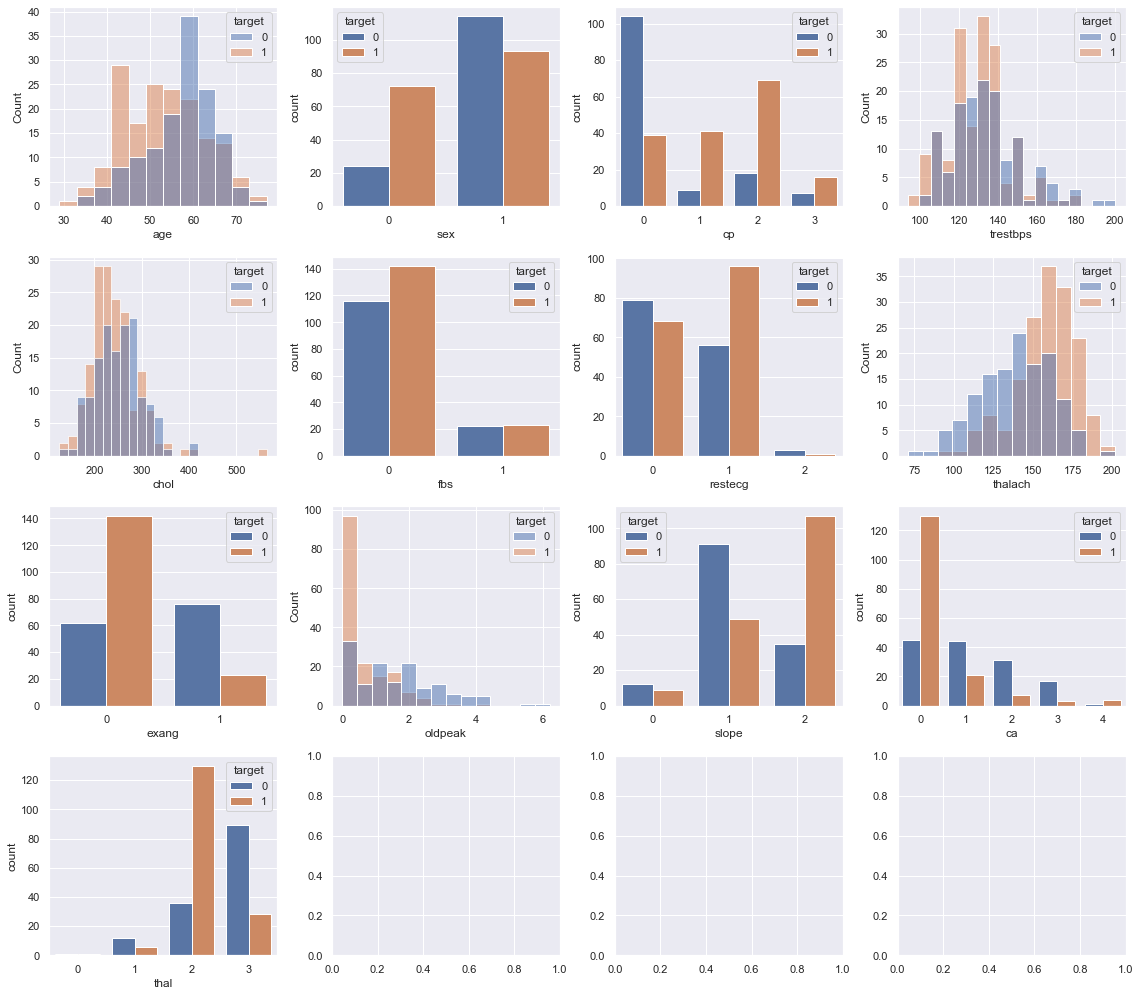

In [35]:
fig, axes = plt.subplots(4,4,figsize=(16,14));

for i, c in enumerate(heart.columns[:-1]):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        a = sns.countplot(x=c,data=heart, ax=ax, hue='target');
    else: 
        sns.histplot(x=c,data=heart, hue='target',ax=ax);
plt.tight_layout();

### Resampling protocol

We have a bit more samples that before, so this time we are going to use a train val test strategy. The previous strategy would be a good choice, as we do not have a lot of samples and the models we are using are fast, but we are going to use the train val test strategy instead so you have an example of both. 

In [36]:
X = heart.loc[:,heart.columns != 'target']
y = heart['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


### Preprocessing

We have different ranges and categorical variables this time. 
We should handle these two problems in our pre-processing.
Notice the different treatment of training set and validation and test sets.

In [37]:
def preprocessing(X, y, scaler=None):    
    # We scale the numerical columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X.loc[:,numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X.loc[:,numerical_cols] = scaler.transform(X[numerical_cols]) 
    # We apply one-hot-encoding to the categorical columns 
    X = pd.get_dummies(X,drop_first=True)
    return X, y, scaler


X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val,y_val,scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

### Choosing our metrics

We are going to use the LDA validation results to explain which metrics we are using and why. 

This time we want to avoid missing any patients with a heart condition, so classifying a 1 as a 0 will be very harmful to our model. 

In [38]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)

LinearDiscriminantAnalysis()

In [39]:
confusion(pd.Series(y_val), pd.Series(y_pred_lda))

predicted,0,1
target,,
0,25,6
1,2,34


If we look into our confusion matrix, we have 2 samples that had a heart disease that where classified as healthy. 
That is a 5% of dead patients (which is unacceptable). We want to select a metric that penalizes this (i.e. will be lower when we predict patients with the disease wrongly). 

So our best choice would be the **recall of the class 1**. If you remember the recall formula: 
$$recall_c =\frac{tp}{tp + fn}$$

A recall of 1 would mean 0 samples predicted as false negative, i.e. zero patients with heart disease predicted as healthy.  

If we chose only this metric, we would risk a model that predicts only class 1, that might not be ideal, as we would need to check all the patients, which could saturate the hospital. To avoid this we will also use the **f1-score of the class 1** as secondary metric. 

It is important to be careful while chosing our metrics and addapt the best we can to the context of our problem, so we can really chose the best model for our context (which might not be the one with the best accuracy).

We will print a set of metrics, not just these ones, but these ones are going to be the ones we will use to take our decisions. 

In [40]:
print(classification_report(y_val, y_pred_lda))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        31
           1       0.85      0.94      0.89        36

    accuracy                           0.88        67
   macro avg       0.89      0.88      0.88        67
weighted avg       0.89      0.88      0.88        67



In [41]:
def compute_metrics(y_real,y_pred):
    # By default it will compute the binary recall of class 1, we can specify which class do we want by using this parameter 
    recall_class_1 =recall_score(y_real,y_pred, pos_label=1)
    f1_class_1 =f1_score(y_real,y_pred, pos_label=1)
    accuracy = accuracy_score(y_real,y_pred)
    f1_macro =f1_score(y_real,y_pred, average='macro')
    precison_macro =precision_score(y_real,y_pred,  average='macro')
    recall_macro =recall_score(y_real,y_pred,  average='macro')
    return [recall_class_1, f1_class_1, accuracy,f1_macro,precison_macro,recall_macro ]

In [42]:
results_heart = pd.DataFrame(index=[], columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro'])

results_heart.loc['LDA', :] = compute_metrics(y_val, y_pred_lda)
results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875


### QDA
Now we are going to train the rest of our models with this new dataset. And store our metrics on our results dataframe. 


In [43]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'reg'));
results_qda = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precision Macro', 'Recall Macro']);

regularization_parameters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10];

for reg in regularization_parameters:
    qda_model = QuadraticDiscriminantAnalysis(reg_param=reg);
    qda_model = qda_model.fit(X_train,y_train);
    y_pred = qda_model.predict(X_val);
    results_qda.loc[('QDA',reg), :] = compute_metrics(y_val, y_pred);

results_qda.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model reg                                                             
QDA   1.000e+01              0.944          0.764    0.687    0.649   
      1.000e-01              0.917          0.904    0.896    0.895   
      5.000e+00              0.917          0.825    0.791    0.783   
      1.000e+00              0.889          0.865    0.851    0.849   
      0.000e+00              0.861          0.785    0.746    0.738   
      1.000e-02              0.861          0.838    0.821    0.819   
      5.000e-01              0.861          0.849    0.836    0.834   
      1.000e-04              0.833          0.811    0.791    0.789   
      1.000e-03              0.833          0.811    0.791    0.789   

                Precision Macro Recall Macro  
model reg                                     
QDA   1.000e+01           0.749        0.666  
      1.000e-01           0.896        0.894  
      5.000e+00            0.81        0.781  
      1.000e+00           0.852        0.848  
      0.000e+00           0.756        0.737  
      1.000e-02           0.822        0.818  
      5.000e-01           0.836        0.834  
      1.000e-04           0.791        0.788  
      1.000e-03           0.791        0.788

According to our validation results, the best parameter is 10. We will use this model to compare with the rest.

In [45]:
qda_model = QuadraticDiscriminantAnalysis(reg_param=10);
qda_model = qda_model.fit(X_train,y_train);
y_pred_qda = qda_model.predict(X_val);

results_heart.loc['QDA-10', :] = compute_metrics(y_val, y_pred_qda)
results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666


### KNN 

Lets follow the same process with knn.

In [46]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'));
results_knn = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

k_values = range(1,50,2);

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k);
    knn = knn.fit(X_train,y_train);
    y_pred = knn.predict(X_val);
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred);

results_knn.sort_values(by='**Recall class 1**',ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro Precission Macro  \
model k                                                                         
KNN   49              0.917           0.88    0.866    0.864             0.87   
      47              0.917           0.88    0.866    0.864             0.87   
      27              0.889          0.865    0.851    0.849            0.852   
      45              0.889          0.865    0.851    0.849            0.852   
      31              0.889          0.865    0.851    0.849            0.852   
      29              0.889          0.865    0.851    0.849            0.852   
      43              0.861          0.849    0.836    0.834            0.836   
      41              0.861          0.849    0.836    0.834            0.836   
      39              0.861          0.849    0.836    0.834            0.836   
      37              0.861          0.849    0.836    0.834            0.836   
      35              0.861          0.849    0.836    0.834            0.836   
      33              0.861          0.849    0.836    0.834            0.836   
      25              0.833          0.833    0.821     0.82             0.82   
      23              0.833          0.833    0.821     0.82             0.82   
      21              0.833          0.833    0.821     0.82             0.82   
      19              0.833          0.833    0.821     0.82             0.82   
      17              0.833          0.833    0.821     0.82             0.82   
      3               0.806          0.795    0.776    0.774            0.775   
      13              0.806          0.841    0.836    0.836            0.836   
      15              0.778          0.824    0.821    0.821            0.823   
      11               0.75          0.806    0.806    0.806             0.81   
      9                0.75          0.806    0.806    0.806             0.81   
      7                0.75          0.794    0.791    0.791            0.793   
      1                0.75           0.73    0.701    0.698              0.7   
      5               0.722          0.732    0.716    0.715            0.715   

         Recall Macro  
model k                
KNN   49        0.862  
      47        0.862  
      27        0.848  
      45        0.848  
      31        0.848  
      29        0.848  
      43        0.834  
      41        0.834  
      39        0.834  
      37        0.834  
      35        0.834  
      33        0.834  
      25         0.82  
      23         0.82  
      21         0.82  
      19         0.82  
      17         0.82  
      3         0.774  
      13        0.838  
      15        0.824  
      11         0.81  
      9          0.81  
      7         0.794  
      1         0.698  
      5         0.716

According to our metrics we will chose k = 49.

In [47]:
knn = KNeighborsClassifier(n_neighbors=49);
knn = knn.fit(X_train,y_train);
y_pred_knn = knn.predict(X_val);
results_heart.loc['KNN-49', :] = compute_metrics(y_val, y_pred_knn);
results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862


### Naive Bayes

Our final model, now we are going to use Naive Bayes in two different ways. First we are going to use gaussian naive bayes, asuming our variables are numerical. This is not fully true, as some of them are categorical variables transformed with a one-hot encoding. 

In the second way we will try to take advantage of these categorical variables by using to different naive bayes model, one categorical for the categorical variables and one gaussian for the numerical. As it is a probabilistic classifier we can use probabilities from both classifiers to predict our samples.  

In [48]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train,y_train)
y_pred_gnb = gaussian_nb.predict(X_val);

results_heart.loc['Gaussian-NB', :] = compute_metrics(y_val, y_pred_gnb);
results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862
Gaussian-NB,0.861,0.849,0.836,0.834,0.836,0.834


In [49]:
def preprocessing_only_numerical(X, scaler=None):    
    # We scale the numerical columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X.loc[:,numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X.loc[:,numerical_cols] = scaler.transform(X[numerical_cols]) 
    return X, scaler


# We need to load again our data so we can pre-process it differently
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


X_train_numerical, scaler = preprocessing_only_numerical(X_train[numerical_cols])
X_train_categorical = X_train[categorical_cols]

X_val_numerical, _ = preprocessing_only_numerical(X_val[numerical_cols], scaler)
X_val_categorical = X_val[categorical_cols]

X_test_numerical, _ = preprocessing_only_numerical(X_test[numerical_cols], scaler)
X_test_categorical = X_test[categorical_cols]

In [50]:
gaussian_nb = GaussianNB()
gaussian_nb = gaussian_nb.fit(X_train_numerical,y_train)
y_pred_gnb_num = gaussian_nb.predict(X_val_numerical);

results_heart.loc['Gaussian-NB-only-numerical', :] = compute_metrics(y_val, y_pred_gnb_num);


cat_nb = CategoricalNB()
cat_nb = cat_nb.fit(X_train_categorical,y_train)
y_pred_gnb_cat = cat_nb.predict(X_val_categorical);

results_heart.loc['Gaussian-NB-only-categorical', :] = compute_metrics(y_val, y_pred_gnb_cat);

results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862
Gaussian-NB,0.861,0.849,0.836,0.834,0.836,0.834
Gaussian-NB-only-numerical,0.806,0.753,0.716,0.71,0.719,0.709
Gaussian-NB-only-categorical,0.861,0.861,0.851,0.85,0.85,0.85


Now we are going to use our probabilistic classifiers trick, we can use the probabilities prediction together by multiplying them, sometimes this kind of aggregation can improve the results of the two independent models. 

We can see on our results that this is not the case. For some reason our only numerical naive bayes is not working super well and it looks like it is affecting the aggregated results.

In [51]:
combined_prediction_proba= cat_nb.predict_proba(X_val_categorical) * gaussian_nb.predict_proba(X_val_numerical)

combined_prediction = np.argmax(combined_prediction_proba,axis=1)

results_heart.loc['Combined-NB', :] = compute_metrics(y_val, combined_prediction);
results_heart

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862
Gaussian-NB,0.861,0.849,0.836,0.834,0.836,0.834
Gaussian-NB-only-numerical,0.806,0.753,0.716,0.71,0.719,0.709
Gaussian-NB-only-categorical,0.861,0.861,0.851,0.85,0.85,0.85
Combined-NB,0.861,0.861,0.851,0.85,0.85,0.85


Now there is a last probability trick that we can use. As we want to be completely sure that our model is predicting 0 only when the patient is not diseased, instead of selecting the class with the maximum probability value, we can select class 0 only when the combined probability of class 0 is greater than 0.6.   

In [52]:
def only_cero_when_you_are_sure(x):
    if x[0] > 0.6:
        return 0
    else:
        return 1

combined_pred_tuned = pd.DataFrame(combined_prediction_proba).apply(only_cero_when_you_are_sure, axis=1)

results_heart.loc['Combined-NB-tuned', :] = compute_metrics(y_val, combined_pred_tuned);

results_heart.sort_values(by='**Recall class 1**',ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Combined-NB-tuned,0.972,0.814,0.761,0.74,0.821,0.744
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862
Gaussian-NB,0.861,0.849,0.836,0.834,0.836,0.834
Gaussian-NB-only-categorical,0.861,0.861,0.851,0.85,0.85,0.85
Combined-NB,0.861,0.861,0.851,0.85,0.85,0.85
Gaussian-NB-only-numerical,0.806,0.753,0.716,0.71,0.719,0.709


### Logistic regression

The last model we are going to compare is (regularized) Logistic regression. We are going to optimize its regularization parameter as in the other models, by picking the one that maximizes recall on class 1 on the validation set.

In [53]:
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'));
results_logreg = pd.DataFrame(index=index, columns= ['**Recall class 1**', '**F1 class 1**','Accuracy', 'F1 Macro', 'Precission Macro', 'Recall Macro']);

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C);
    logreg = logreg.fit(X_train,y_train);
    y_pred = logreg.predict(X_val);
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred);

results_logreg.sort_values(by='**Recall class 1**', ascending=False)

**Recall class 1** **F1 class 1** Accuracy F1 Macro  \
model  C                                                              
LogReg 0.1                   0.944          0.883    0.866    0.863   
       100000.0              0.917           0.88    0.866    0.864   
       1000.0                0.917           0.88    0.866    0.864   
       100.0                 0.917           0.88    0.866    0.864   
       10.0                  0.917           0.88    0.866    0.864   
       10000.0               0.889          0.865    0.851    0.849   
       1.0                   0.889          0.865    0.851    0.849   

                Precission Macro Recall Macro  
model  C                                       
LogReg 0.1                 0.876        0.859  
       100000.0             0.87        0.862  
       1000.0               0.87        0.862  
       100.0                0.87        0.862  
       10.0                 0.87        0.862  
       10000.0             0.852        0.848  
       1.0                 0.852        0.848

It seems the best logistic regression model according to recall on class 1 is with regularization parameter C=0.1. Let us use this model and compare it to the others.

In [54]:
logreg = LogisticRegression(C=0.1).fit(X_train,y_train);
y_pred_logreg = logreg.predict(X_val);
results_heart.loc['LogReg-0.1', :] = compute_metrics(y_val, y_pred_logreg);

results_heart.sort_values(by='**Recall class 1**', ascending=False)

,**Recall class 1**,**F1 class 1**,Accuracy,F1 Macro,Precision Macro,Recall Macro
Combined-NB-tuned,0.972,0.814,0.761,0.74,0.821,0.744
LDA,0.944,0.895,0.881,0.878,0.888,0.875
QDA-10,0.944,0.764,0.687,0.649,0.749,0.666
LogReg-0.1,0.944,0.883,0.866,0.863,0.876,0.859
KNN-49,0.917,0.88,0.866,0.864,0.87,0.862
Gaussian-NB,0.861,0.849,0.836,0.834,0.836,0.834
Gaussian-NB-only-categorical,0.861,0.861,0.851,0.85,0.85,0.85
Combined-NB,0.861,0.861,0.851,0.85,0.85,0.85
Gaussian-NB-only-numerical,0.806,0.753,0.716,0.71,0.719,0.709


This way we are obtaining the best model in terms of recall of the class 1. Notice that this model is not the best in terms of the F1 of class 1 nor the F1 Macro.  If we check our confusion matrix we can see that this model has predicted almost all patients correctly at the cost of having worse performance on the other class. 

In this specific context we wanted to absolutly prioritize avoiding misclassifying class 1. So our best choice would be the **Combined Naive Bayes Tuned**, if our criteria was different or the importance of missclasifying was more balanced between the classes the best model would be **LDA**.

In [55]:
print('Combined Naive Bayes Tuned')
confusion(y_val, combined_pred_tuned)

print('LDA')
confusion(y_val, pd.Series(y_pred_lda))

print('QDA')
confusion(y_val, pd.Series(y_pred_qda))

print('Logistic Regression')
confusion(y_val, pd.Series(y_pred_logreg))

Combined Naive Bayes Tuned


predicted,0,1
target,,
0,16,15
1,1,35


LDA


predicted,0,1
target,,
0,25,6
1,2,34


QDA


predicted,0,1
target,,
0,12,19
1,2,34


Logistic Regression


predicted,0,1
target,,
0,24,7
1,2,34


### See generalization performance

Now that we have decided our model. As there are no more decisions to make we can now check its generalization performance. To ensure that this generalization performance is the closest posible to the performance we would obtain on new data, we are going to use our test partition to evaluate it. 

This time we can see the confusion matrix, as well as the classification report for the test set. This will give us the most detailed possible information about our results.

These results are quite similar to the validation ones. 

In [56]:
combined_prediction_proba_test= cat_nb.predict_proba(X_test_categorical) * gaussian_nb.predict_proba(X_test_numerical)
combined_pred_tuned_test = pd.DataFrame(combined_prediction_proba_test).apply(only_cero_when_you_are_sure, axis=1)

confusion(y_test, pd.Series(combined_pred_tuned_test))

print(classification_report(y_test, combined_pred_tuned_test))

predicted,0,1
target,,
0,20,27
1,1,52


              precision    recall  f1-score   support

           0       0.95      0.43      0.59        47
           1       0.66      0.98      0.79        53

    accuracy                           0.72       100
   macro avg       0.81      0.70      0.69       100
weighted avg       0.80      0.72      0.69       100

